In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.metrics import mean_squared_error, r2_score

import cvxpy as cvx

import pandas_datareader.data as web
import datetime

# Library with returns forecasting models
from PredictionModels import *

Setting the data parameters

In [2]:
tickers = [
    'BTC-USD', # Bitcoin
    'SOL-USD', # Solana
    'ETH-USD', # Etherium
    'MSFT.MX', # Microsoft Corporation
    'GOOG', # Alphabet Inc. (Google)
    'WMT.MX', # Walmart Inc.
    'XOM', # Exxon Mobil Corporation
    'AZN.L', # AstraZeneca PLC
    'DIS.MX', # The Walt Disney Company
    'PG.MX', # The Procter & Gamble Company
    'KIM', # Kimco Realty Corporation
]

# Market capitalization in $Bln
caps = {
    'BTC-USD': 1751,
    'SOL-USD': 71.991,
    'ETH-USD': 191.258,
    'MSFT.MX': 52592,
    'GOOG': 1855,
    'WMT.MX': 14980,
    'XOM': 462.46,
    'AZN.L': 156.814,
    'DIS.MX': 3057,
    'PG.MX': 7980,
    'KIM': 13.991
}

start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'

Determining the Markowitz model

In [3]:
class Markowitz(DataStore):
    def __init__(self, tickers=[], start_date = '2010-01-01', end_date = '2025-04-20', period = '1d', caps = caps):
        super().__init__(tickers, start_date, end_date, period, caps=caps)
        self.exp_returns = self.data[1].mean() * 252 # If we have daily data
        self.cov = self.data[1].cov() * 252
        self.length = self.exp_returns.shape[0]
    def optimize(self):
        """
        The function optimizes the weights using Markowitz approach 
        The function returns optimized weights for Markowitz portfolio            
        """
        Q = np.array(self.cov)
        q = np.array(self.exp_returns)
        # Inequalities are written as Gx <= h
        G = np.diag(-1*np.ones(self.length), 0) 
        h = np.zeros(self.length, dtype=int)
        # Equality constraints are written as Ax == b
        A = np.ones(self.length, dtype=int)
        b = np.array([1])
        # Defining and solving the quandratic problem 
        x = cvx.Variable(self.length)
        prob = cvx.Problem(cvx.Maximize((-1/2)*cvx.quad_form(x, Q) + q.T @ x),
            [G @ x <= h, A @ x == b])
        prob.solve()

        # Retrieving the weights
        x_values = x.value
        w = dict()
        for i in range(self.length):
            w[self.tickers[i]] = round(x_values[i], 4)
    
        return w
    
    def plot_weights(self):
        weights = self.optimize()
        fig = plt.figure(figsize=(15,5))
        plt.bar(weights.keys(), weights.values(), color='b', width=0.7)
        plt.title("Asset allocation by Markowitz model", y=1.05)
        plt.xlabel("Investment assets")
        plt.ylabel("Weights of assets in Markowitz portfolio")
        plt.grid()
        plt.show()
        

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  11 of 11 completed


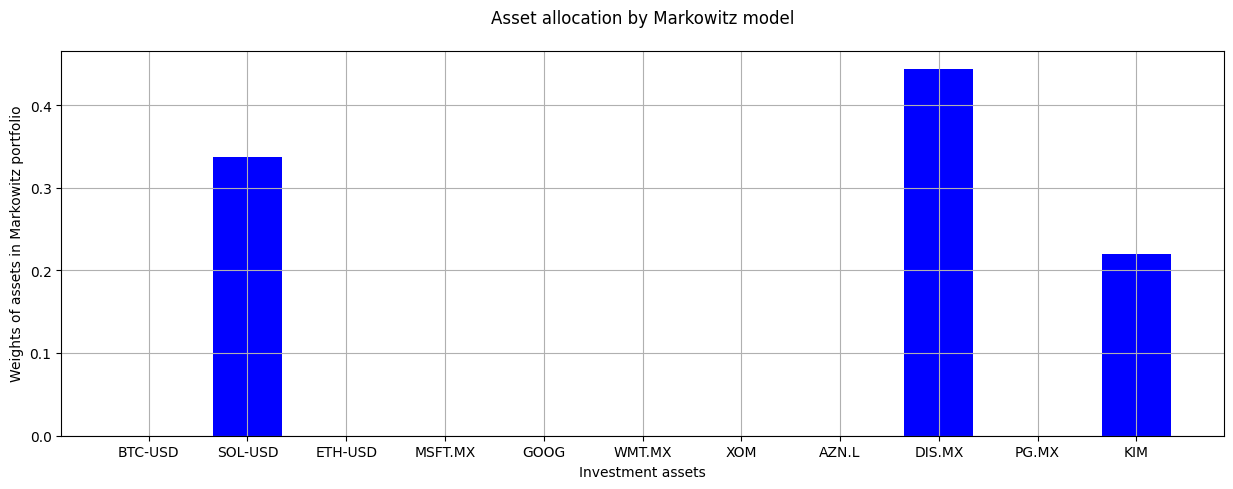

In [4]:
markowitz_model = Markowitz(tickers=tickers, start_date=start_date, end_date=end_date, period=period, caps=caps)
opt_weights = markowitz_model.optimize()
markowitz_model.plot_weights()

Black-Litterman model

In [9]:
class BlackLitterman(DataStore):
    def __init__(self, tickers=[], start_date = '2010-01-01', end_date = '2025-04-20', period = '1d', caps=caps):
        super().__init__(tickers, start_date, end_date, period, caps=caps)

        # Loading additional data of 3-month US treasure rates to calculate excess returns
        self.tickers = tickers
        self.start_date = start_date
        self.end_data = end_date
        self.t_rates = web.DataReader("TB3MS", 'fred', start=self.start_date, end=self.end_date)
        self.t_rates.reset_index(inplace=True)
        self.t_rates.rename(columns={"DATE": "Date"}, inplace=True)
        self.t_rates['TB3MS'] = self.t_rates['TB3MS'] / 100
        self.data[1].reset_index(inplace=True)

        # Merging the assets data and T-bill data
        self.full_data = pd.merge(self.data[1], self.t_rates, how='left', on='Date')
        # Filling in the gaps
        self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
        self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(0.0015)
        # Converting the rates into 1 day rate by dividing by 90 days
        self.full_data['TB3MS'] = self.full_data['TB3MS'] / 90

        # Dividing the data into treasury returns and other assets returns
        self.assets_returns = self.full_data[self.tickers]
        self.treasury_rate = self.full_data["TB3MS"]

    def equil_weights(self):
        """
            The function returns equilibrium weights calculated using market capitalization of assets (Yahoo Finance)
        """
        asset_weights = pd.DataFrame(self.caps.values(), index=self.caps.keys(), columns=['Cap'])
        asset_weights['Weights'] = asset_weights['Cap'].apply(lambda x: x / asset_weights['Cap'].sum())
        return asset_weights

    def implied_equil_returns(self):
        """ 
        
        """
        assets_weights = self.equil_weights()
        excess_returns = self.assets_returns.subtract(self.treasury_rate, axis=0)
        # Calculation of excess returns covariance matrix 
        covar = excess_returns.cov() * 252
                # Risk-aversion parameter
        risk_aversion = 2.95
        print("risk_aversion=",risk_aversion)
        
        return self.implied_function(risk_aversion, covar, assets_weights['Weights'])


    def implied_function(self, risk_avers_param, sig, weights):
        """
            The function calculates equlibrium market returns

            Arg:
                - risk_avers_param (float) - risk-aversion parameter
                - sig (np.array) - covariance matrix of excess returns
                - weights (pd.Series) - equilibrium market weights 
            return: equlibrium market returns
        """

        return risk_avers_param * sig.dot(weights).squeeze()


    def views_function(self):
        pass

    def function(self, predictions: dict, method: str):
        """
        The function returns the views matrix based on predictions
        """
        pass


    def function1(self):
        """
        The function does some!
        """
        
        pass


    def consolid_preds(self):
        """ 
        The function stores expected returns for each asset based on different models predictions
        """
        self.q_matrix = np.zeros(len(self.tickers))

        # Container of forecasts
        preds = np.zeros((3, len(self.tickers)))
        
        for i, ticker in enumerate(self.tickers):
            # Initializing the prediction models

            # DesicionTreeRegressor
            des_tree = DesicionTreeRegressorPredictor(
                ticker=ticker,
                start_date=self.start_date, # At this point I set start_date at default (dynamicaly it will differ or will be fixed)
                end_date=self.end_date,     # At this point I set end_date at default (dynamicaly it will differ)
                features_target=self.features_target
            )    
            # LogisticRegression
            log_reg = LinearRegressionPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )

            svr_reg = SVRPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )
            
            # Making forecasts
            preds[0, i] = des_tree.make_forecast()[0]
            preds[1, i] = log_reg.make_forecast()[0]
            preds[2, i] = svr_reg.make_forecast()[0]

        return preds


In [10]:
# Checking the process
bl = BlackLitterman(tickers, start_date, end_date, period)
w = bl.implied_equil_returns()
w

[*********************100%***********************]  11 of 11 completed


risk_aversion= 2.95


C:\Users\Acer\AppData\Local\Temp\ipykernel_9152\3399300394.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")


BTC-USD    0.105404
SOL-USD    0.166755
ETH-USD    0.134828
MSFT.MX    0.162294
GOOG       0.102142
WMT.MX     0.072481
XOM       -0.002744
AZN.L      0.005930
DIS.MX     0.080298
PG.MX      0.050637
KIM        0.016582
dtype: float64

In [11]:
forecasts = bl.consolid_preds()
forecasts

array([[ 1.48351265e-02, -4.59906494e-02, -1.48701586e-02,
        -4.21457312e-02,  7.46064332e-02,  0.00000000e+00,
         4.01538131e-03, -9.67349728e-03,  5.62882959e-03,
        -3.16651883e-04,  1.15324515e-02],
       [ 2.44077810e-03,  6.33145790e-03,  3.98107453e-03,
         2.90073381e-03, -5.37901831e-03,  4.02189594e-03,
         8.09852246e-03,  5.09290471e-03,  3.77393898e-03,
        -3.65949207e-04,  5.45742581e-03],
       [-4.96153220e-03,  1.40476548e-02, -4.40489765e-02,
         3.12711954e-04, -3.15983817e-03, -2.56858081e-02,
         1.85353658e-02, -8.41017207e-03,  8.53835192e-03,
        -2.34481411e-05,  1.73766289e-02]])